# install Requirments

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install Ipython
!pip install pyvirtualdisplay
!pip install gym.wrappers
!pip install pygame
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gym.wrappers: filename=gym_wrappers-0.1.0-py3-none-any.whl size=1412 sha256=a4ad3e8a45c8beb4166ad13ad58712a01a7aa6f468d81efaffc6bfd8d3c6c8dd
  Stored in directory: /root/.cache/pip/wheels/bf/e5/1a/7a9feba5120117a78b2fe42ef373e998ae2dcc068514794768
Successfully built gym.wrappers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 67.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 KB 41.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
  Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https:

# import Libraries

In [3]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import warnings

import numpy as np
from collections import deque, namedtuple

# For visualization
from gym.wrappers import RecordEpisodeStatistics
from gym.wrappers import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

# Video Functions

In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = RecordVideo(env, './video' )
    return env

        
def show_video_of_model(agent, env_name):
    env_to_wrap = gym.make(env_name)
    env = wrap_env(env_to_wrap)
    agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        env.render()
        action = agent.act(state)

        state, reward, done, _ = env.step(action)        
    env.close()


# Test environment

In [5]:
warnings.filterwarnings('ignore')
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)


State shape:  (8,)
Number of actions:  4


# Hyper Parameters

In [6]:
BUFFER_SIZE = int(1e3)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

# Classes & Functions

In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
class Agent():

    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        ### bellman equation
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        ### expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)
        
        ### Loss calculation
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [10]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [11]:
def Reward_function(env,prev_shaping,state,action):
    reward = 0
    shaping = (
        -100 * np.sqrt(state[0] * state[0] + state[1] * state[1])
        - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])
        - 100 * abs(state[4])
        + 10 * state[6]
        + 10 * state[7]
    ) 
    if prev_shaping is not None:
        reward = shaping - prev_shaping
    prev_shaping = shaping

    m_power = 0.0
    if (env.continuous and action[0] > 0.0) or (
        not env.continuous and action == 2
    ):
        # Main engine
        if env.continuous:
            m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
            assert m_power >= 0.5 and m_power <= 1.0
        else:
            m_power = 1.0

    s_power = 0.0
    if (env.continuous and np.abs(action[1]) > 0.5) or (
        not env.continuous and action in [1, 3]
    ):
        # Orientation engines
        if env.continuous:
            s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
            assert s_power >= 0.5 and s_power <= 1.0
        else:
            s_power = 1.0

    reward -= (
    m_power * 0.30
    )  # less fuel spent is better, about -30 for heuristic landing
    reward -= s_power * 0.03

    if env.game_over or abs(state[0]) >= 1.0:
        reward = -100
    if not env.lander.awake:
        reward = +100
    return reward, prev_shaping

In [12]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    prev_shaping = None
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        prev_shaping = None
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            reward, prev_shaping = Reward_function(env,prev_shaping,next_state,action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 50 == 0:
            pth_adr = 'path' + str(i_episode) + '.pth'
            torch.save(agent.qnetwork_local.state_dict(), pth_adr)
            print('\n Path saved as {}'.format(pth_adr))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores



# Train

In [13]:
agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 50	Average Score: -182.39
 Path saved as path50.pth
Episode 100	Average Score: -165.97
 Path saved as path100.pth
Episode 100	Average Score: -165.97
Episode 150	Average Score: -134.24
 Path saved as path150.pth
Episode 200	Average Score: -101.53
 Path saved as path200.pth
Episode 200	Average Score: -101.53
Episode 250	Average Score: -82.66
 Path saved as path250.pth
Episode 300	Average Score: -73.25
 Path saved as path300.pth
Episode 300	Average Score: -73.25
Episode 350	Average Score: -67.03
 Path saved as path350.pth
Episode 400	Average Score: -53.43
 Path saved as path400.pth
Episode 400	Average Score: -53.43
Episode 450	Average Score: -22.63
 Path saved as path450.pth
Episode 500	Average Score: -5.55
 Path saved as path500.pth
Episode 500	Average Score: -5.55
Episode 550	Average Score: 8.18
 Path saved as path550.pth
Episode 600	Average Score: 41.18
 Path saved as path600.pth
Episode 600	Average Score: 41.18
Episode 650	Average Score: 88.38
 Path saved as path650.pth
Episod

## score per episode

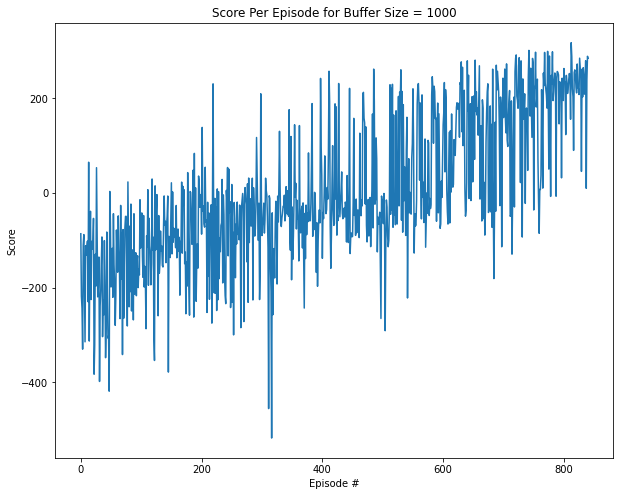

In [19]:
fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Score Per Episode for Buffer Size = {}'.format(BUFFER_SIZE))
plt.show()

## Train Video

In [14]:
def show_video_of_train(agent, env_name, path_adr):
    sum_rew = 0
    env_to_wrap = gym.make(env_name)
    env = wrap_env(env_to_wrap)
    agent.qnetwork_local.load_state_dict(torch.load(path_adr))
    state = env.reset()
    done = False
    while not done:
        env.render()
        action = agent.act(state)
        state, reward, done, _ = env.step(action)  
        sum_rew +=  reward 
     
    env.close()
    return sum_rew, env.game_over

In [15]:
for i in range(len(scores)):
  if i % 50 == 0 and i>0:
    agent = Agent(state_size=8, action_size=4, seed=0)
    pth_adr = 'path' + str(i) + '.pth'
    sum_rew, gover = show_video_of_train(agent, 'LunarLander-v2', pth_adr)
    print(pth_adr)
    print('Sum of rewards = {} game_over = {}'.format(sum_rew, gover))
    show_video()

path50.pth
Sum of rewards = -826.3255696398983 game_over = False


path100.pth
Sum of rewards = -222.40705591773462 game_over = False


path150.pth
Sum of rewards = -102.43067408299785 game_over = True


path200.pth
Sum of rewards = -19.758778419788918 game_over = False


path250.pth
Sum of rewards = -169.5128894001404 game_over = True


path300.pth
Sum of rewards = -95.25556589320074 game_over = False


path350.pth
Sum of rewards = 152.0641135931001 game_over = False


path400.pth
Sum of rewards = 143.11587744898884 game_over = False


path450.pth
Sum of rewards = -90.2987080332471 game_over = True


path500.pth
Sum of rewards = -67.92545851419885 game_over = False


path550.pth
Sum of rewards = 225.10274444289809 game_over = False


path600.pth
Sum of rewards = 157.85384766308493 game_over = False


path650.pth
Sum of rewards = 156.91297728158173 game_over = False


path700.pth
Sum of rewards = 115.40168027867101 game_over = False


path750.pth
Sum of rewards = 180.37430543578606 game_over = False


path800.pth
Sum of rewards = 266.1020018022725 game_over = False


# Test

In [22]:
agent = Agent(state_size=8, action_size=4, seed=0)
show_video_of_model(agent, 'LunarLander-v2')

In [23]:
show_video()

In [18]:
!zip -r content.zip /content/*

  adding: content/checkpoint.pth (deflated 12%)
  adding: content/path100.pth (deflated 11%)
  adding: content/path150.pth (deflated 11%)
  adding: content/path200.pth (deflated 11%)
  adding: content/path250.pth (deflated 11%)
  adding: content/path300.pth (deflated 11%)
  adding: content/path350.pth (deflated 11%)
  adding: content/path400.pth (deflated 11%)
  adding: content/path450.pth (deflated 11%)
  adding: content/path500.pth (deflated 11%)
  adding: content/path50.pth (deflated 11%)
  adding: content/path550.pth (deflated 11%)
  adding: content/path600.pth (deflated 11%)
  adding: content/path650.pth (deflated 11%)
  adding: content/path700.pth (deflated 11%)
  adding: content/path750.pth (deflated 11%)
  adding: content/path800.pth (deflated 11%)
  adding: content/sample_data/ (stored 0%)
  adding: content/sample_data/README.md (deflated 42%)
  adding: content/sample_data/anscombe.json (deflated 83%)
  adding: content/sample_data/california_housing_test.csv (deflated 76%)
  a